In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import pickle as pkl
from argparse import ArgumentParser
from copy import deepcopy
from os.path import join as oj
import numpy as np
import torch
from torch import nn
import torch.utils.data
from torch import optim
import pickle
from torch.utils.data import DataLoader, TensorDataset
sys.path.insert(0, "../code_fga")
sys.path.insert(0, "..")
import data_fns
import utils
import pandas as pd
import models
# import cmcrameri.cm as cmc
import torchvision
from matplotlib import pyplot as plt
import matplotlib as mpl
cuda = torch.cuda.is_available()

if not cuda:
    sys.exit()
device = torch.device("cuda")
import data
from sklearn import metrics
import configparser
config = configparser.ConfigParser()
from scipy.stats import wasserstein_distance
config.read("../config.ini")

['../config.ini']

In [3]:
data_path = config["PATHS"]["data_path"]
model_path = config["PATHS"]["model_path"]

fig_path = config["PATHS"]["fig_path"]
PATH_IR_INDEX = oj(data_path,'ir_spectra_index.pkl')
PATH_IR_DATA = oj(data_path,'ir_spectra_data.pkl')


with open(PATH_IR_DATA, 'rb') as pickle_file:
    irdata = pickle.load(pickle_file)
    
with open(PATH_IR_INDEX, 'rb') as pickle_file:
    irindex = pickle.load(pickle_file)
filters = (('state', 'gas'), ('yunits', 'ABSORBANCE'), ('xunits', '1/CM'))
x, y = utils.fixed_domain_filter(irdata, irindex, filters)
x /= x.max(axis=1)[:, None]  # (batch_size, features)
x = x[:, None]
train_idxs, val_idxs, test_idxs = data_fns.get_split(len(x), seed=42)


In [4]:
fnames = sorted([oj(model_path, fname) for fname in os.listdir(model_path) if "pkl" in fname]) 
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in (fnames)] 
results_all = pd.concat(results_list, axis=1).T.infer_objects()


In [5]:
used_idxs= np.arange(len(x))

In [6]:

best_model_idx = results_all.val_auc.argmax()
# best_model_idx =0


In [7]:
matrix_list= []
for i in range(5):
    

    model = models.FGANet(num_input= x.shape[2],
                      num_in_channels=1, 
                      num_output = y.shape[1], 
      
                      conv_channels = results_all.iloc[best_model_idx].num_conv,
                      stride = 1)
    model.load_state_dict(torch.load(oj(model_path,results_all.iloc[i].filename+".pt")))
    print(results_all.iloc[i].filename)

    model.eval();

    W = model.classifier[0].weight.detach().numpy()
    W = W.reshape((17, 8, -1))
    # W_max = np.maximum(W,0).max(axis=1)
    
    W_max = W.max(axis=1)
    # W_max /=W_max.sum(axis=1)[:,None]
    matrix_list.append(np.copy(W_max))
    del model

0572484152
0773684280
1660121033
2305109416
3028357577


In [8]:
b = np.asarray([500*x for x in range(1,9)])
b[0] = 400
a = ((b-400)/17.2).astype(np.int32)

matrix_combined = np.asarray(matrix_list)

In [9]:
colors = ['#5a05fa', '#320594', '#11ccb9', '#018786', '#cb3461', '#792039', '#f5660a', '#8e3d0b',]
# colors = colors[::2]+ colors[1::2]

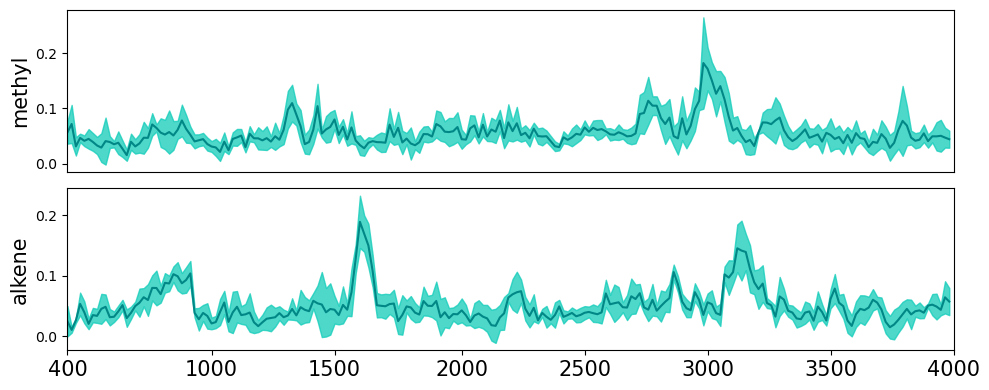

In [10]:
n_func_groups = 2
fig, axes = plt.subplots(nrows =n_func_groups, figsize = (10,4))
for i in range(n_func_groups):

    axes[i].fill_between(np.arange(209),
                         matrix_combined[:,i+1].mean(axis=0) - matrix_combined[:,i+1].std(axis=0), 
                         matrix_combined[:,i+1].mean(axis=0) + matrix_combined[:,i+1].std(axis=0), 
                        alpha = .75, color= colors[2])
    
    axes[i].plot(matrix_combined[:,i+1].mean(axis=0), c= colors[3])
    # axes[i].set_yticks([0, .01, .02],[0, .01, .02], fontsize =10);
    axes[i].set_xticks([], );
    axes[i].set_ylabel(irindex.columns[8+i+1],fontsize =15 );
    axes[i].set_xlim(0,209)
    # axes[i].set_ylim(-0.0015,.02)
plt.xticks(ticks = a,labels = b, fontsize = 15);
plt.tight_layout()
plt.savefig(oj(fig_path, "synchronization_short.pdf"), )

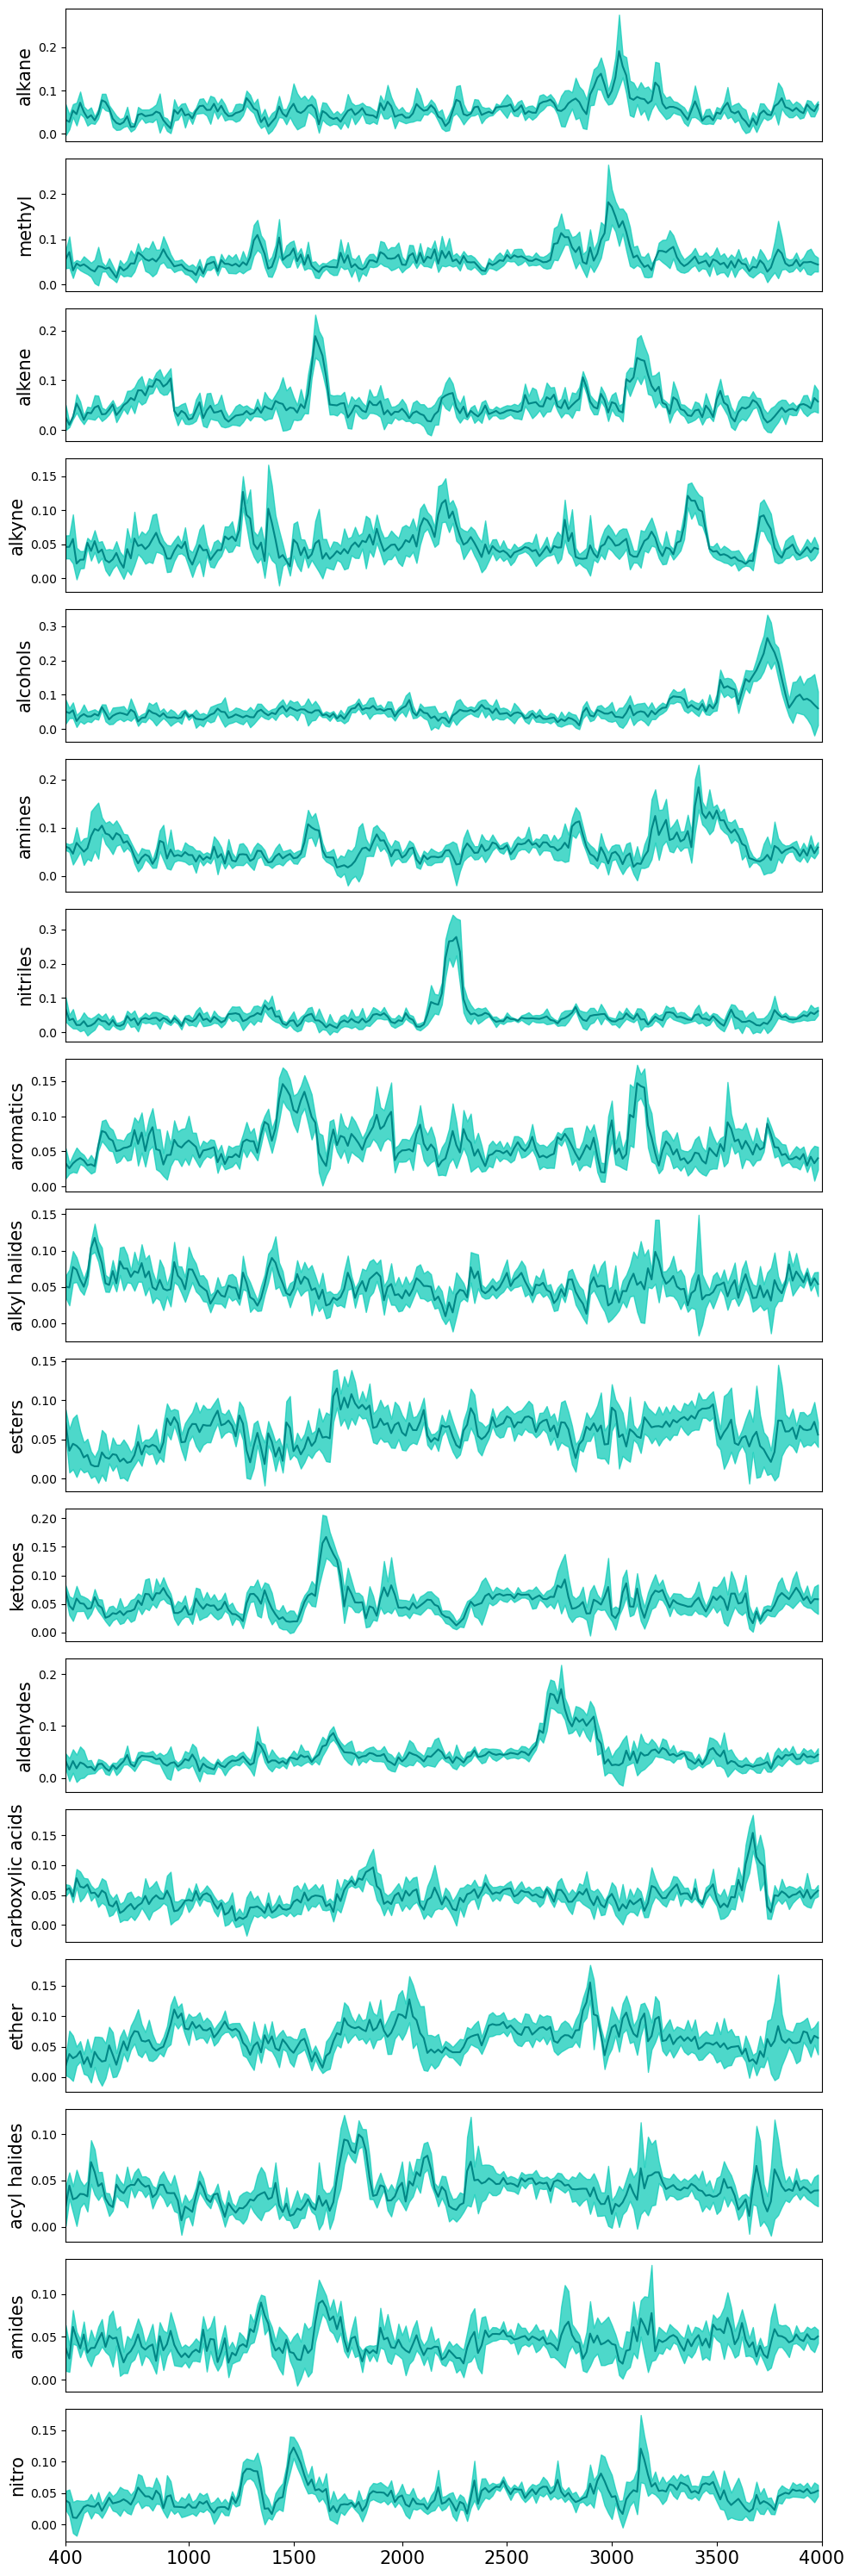

In [11]:
n_func_groups = 17
fig, axes = plt.subplots(nrows =n_func_groups, figsize = (10,30))
for i in range(n_func_groups):

    axes[i].fill_between(np.arange(209),
                         matrix_combined[:,i].mean(axis=0) - matrix_combined[:,i].std(axis=0), 
                         matrix_combined[:,i].mean(axis=0) + matrix_combined[:,i].std(axis=0), 
                        alpha = .75, color= colors[2])
    
    axes[i].plot(matrix_combined[:,i].mean(axis=0), c= colors[3])
    # axes[i].set_yticks([0, .01, .02],[0, .01, .02], fontsize =10);
    axes[i].set_xticks([], );
    axes[i].set_ylabel(irindex.columns[8+i],fontsize =15 );
    axes[i].set_xlim(0,209)
    # axes[i].set_ylim(-0.0015,.02)
plt.xticks(ticks = a,labels = b, fontsize = 15);
plt.tight_layout()
plt.savefig(oj(fig_path, "synchronization.pdf"), )

In [12]:
# n_func_groups = 17
# fig, axes = plt.subplots(nrows =n_func_groups, figsize = (10,30))
# for i in range(n_func_groups):

#     axes[i].fill_between(np.arange(209),np.min(matrix_combined[:,i], axis=0), np.max(matrix_combined[:,i], axis=0))
#     axes[i].set_yticks([], );
#     axes[i].set_xticks([], );
#     axes[i].set_ylabel(irindex.columns[8+i],fontsize =15 );
#     axes[i].set_xlim(0,209)
# plt.xticks(ticks = a,labels = b, fontsize = 15);
# plt.tight_layout()
# plt.savefig(oj(fig_path, "synchronization.pdf"), )

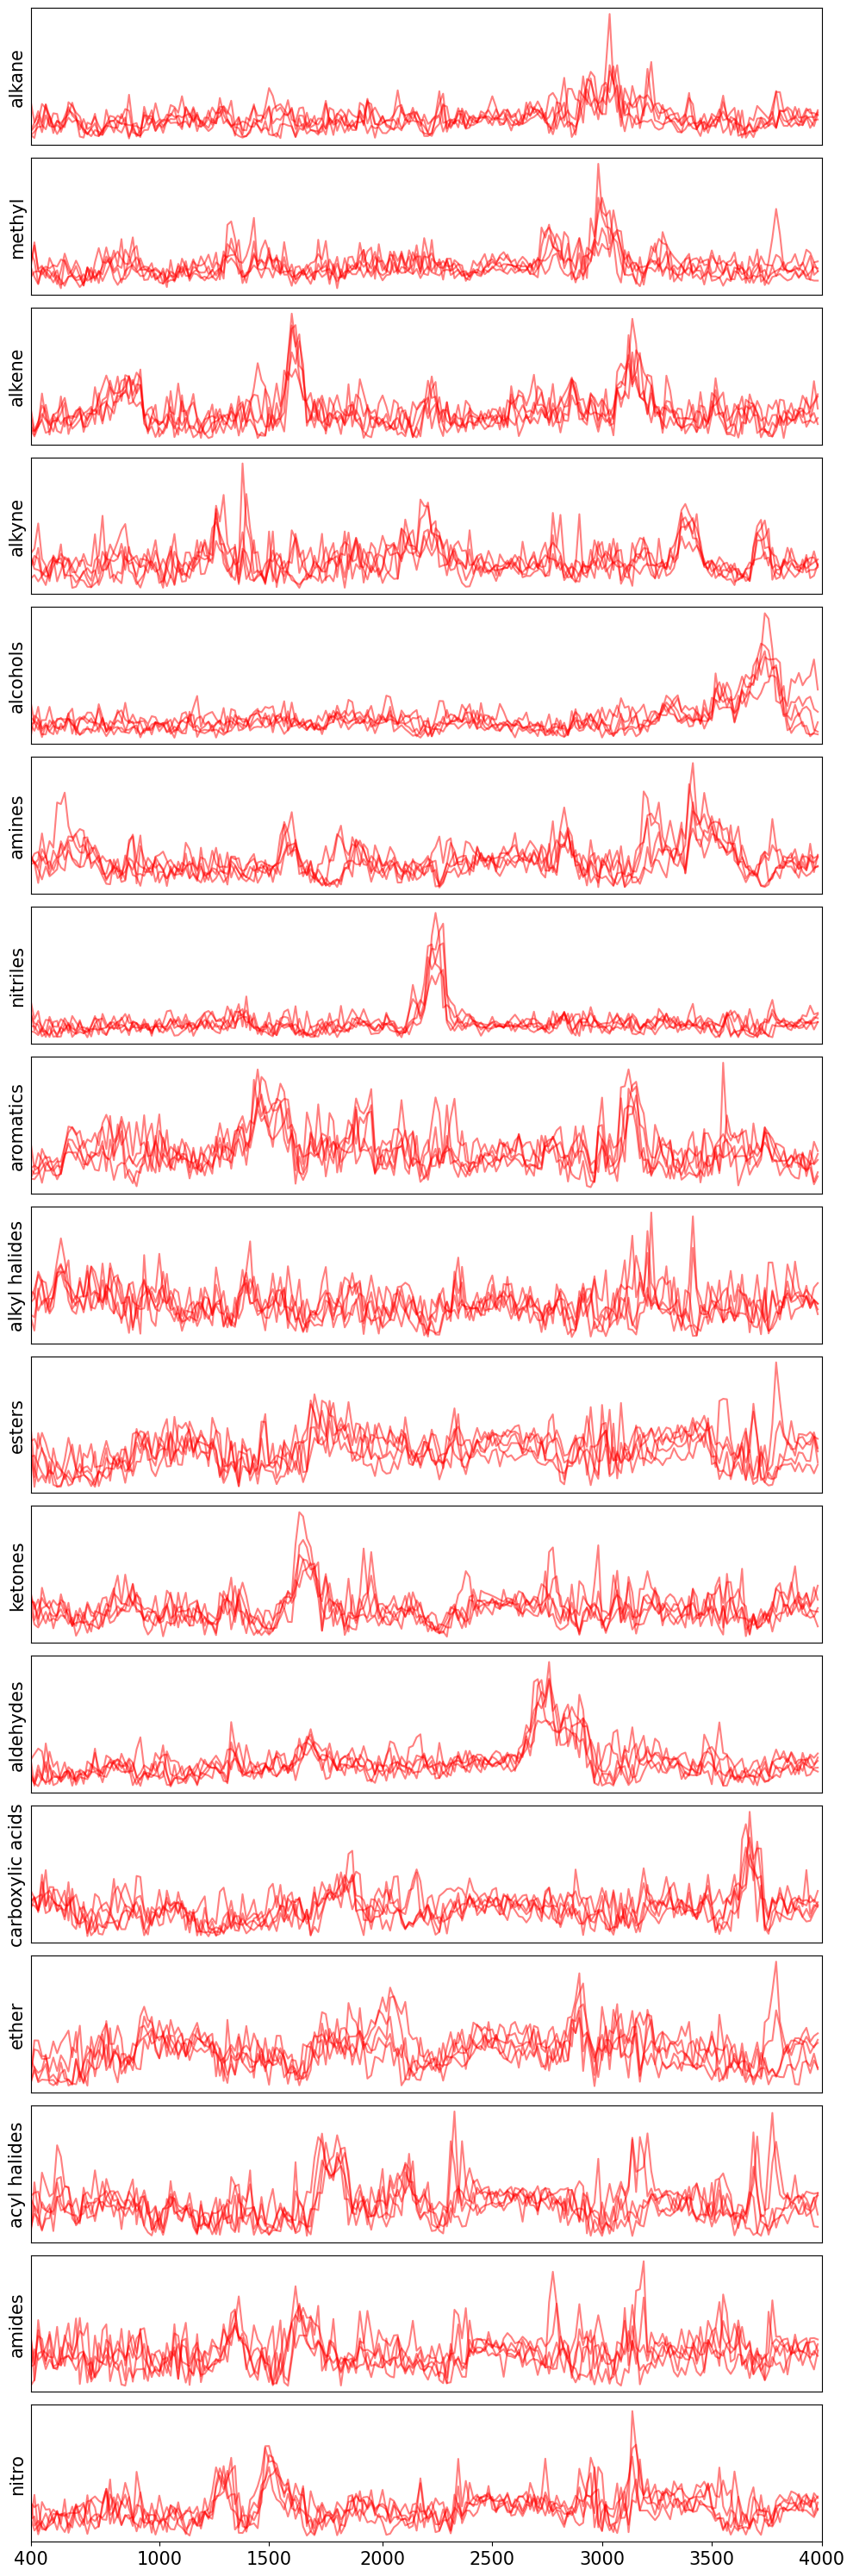

In [13]:
n_func_groups = 17
fig, axes = plt.subplots(nrows =n_func_groups, figsize = (10,30))
for i in range(n_func_groups):
    for j in range(5):
        axes[i].plot(np.abs(matrix_combined[j][i]), c= 'r', alpha =.5)
        axes[i].set_yticks([], );
        axes[i].set_xticks([], );
        axes[i].set_ylabel(irindex.columns[8+i],fontsize =15 );
        axes[i].set_xlim(0,209)
plt.xticks(ticks = a,labels = b, fontsize = 15);
plt.tight_layout()
plt.savefig(oj(fig_path, "synchronization.pdf"), )